# Анализ изменения шрифта в мобильном приложении

**Цель** - исследование результатов A/A/B-эксперимента, в котором 2 контрольные группы со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить, какой шрифт лучше.

**Описание данных**
Каждая запись в логе — это действие пользователя, или событие.
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from scipy import stats as st
import math as mth

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Вывод**
- Пропущенных значений нет
- Необходимо скорректировать название столбцов с использованием строчных букв и "_"
- Проверить наличие дубликатов
- Нужно изменить тип данных с integer на datetime в столбце с датой 'EventTimestamp'

### Подготовка данных

- Скорректируем названия столбцов

In [4]:
data = data.rename(
    columns = {'EventName': 'event_name',
     'DeviceIDHash': 'device_id_hash',
     'EventTimestamp': 'event_timestamp',
     'ExpId': 'exp_id'
        
    }
)
data

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


- Проверим наличие дубликатов

In [5]:
data.duplicated().sum()

413

In [6]:
print('Количеству дубликатов равно', round(data.duplicated().sum()*100/(data['event_name'].count()), 2), '%')

Количеству дубликатов равно 0.17 %


Количество дубликатов меньше 5%, можем удалить их

In [7]:
data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id_hash   244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


- Изменим тип данных на datetime в столбце 'event_timestamp' 

In [8]:
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='s')
data

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246


- Добавим столбец с датой

In [9]:
data['date'] = pd.to_datetime(data['event_timestamp'].dt.date)
data

,event_name,device_id_hash,event_timestamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


- Проверим, есть ли пользователи, которые попали в две или три группы в тесте

In [10]:
double_groups = (data.groupby('device_id_hash').agg({'exp_id':'nunique'}).reset_index())
double_groups = double_groups.loc[(double_groups['exp_id'] == 2) | (double_groups['exp_id'] == 3)]
double_groups.count()

device_id_hash    0
exp_id            0
dtype: int64

В разные группы не попали одни и те же пользователи.

**Вывод**

Данные достаточно качественные: нет пропущенных значений, количество дубликатов незначительное - 0.17 % (Их удалили).
Преобразован формат време в datetime.
При разделении для A/A/B теста в разных группах нет дублирующихся пользователей.

### Обзор и проверка данных

- Посчитаем количество событий в логе

In [11]:
print('количество событий в логе', data['event_name'].count())

количество событий в логе 244126


- Посчитаем количество пользователей в логе

In [12]:
print('количество пользователей в логе', data['device_id_hash'].nunique())

количество пользователей в логе 7551


- Посчитаем среднее количество событий на пользователя

In [13]:
users_groupted = data.groupby('device_id_hash').count()
users_groupted

,event_name,event_timestamp,exp_id,date
device_id_hash,,,,
6888746892508752,1,1,1,1
6909561520679493,5,5,5,5
6922444491712477,47,47,47,47
7435777799948366,6,6,6,6
7702139951469979,137,137,137,137
...,...,...,...,...
9217594193087726423,9,9,9,9
9219463515465815368,17,17,17,17
9220879493065341500,7,7,7,7


In [14]:
print('Значение медианы количества событий на одного пользователя равно', round(users_groupted['event_name'].median(), 2))

Значение медианы количества событий на одного пользователя равно 20.0


- Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [15]:
print('Минимальная дата', data['date'].min())

Минимальная дата 2019-07-25 00:00:00


In [16]:
print('Максимальная дата', data['date'].max())

Максимальная дата 2019-08-07 00:00:00


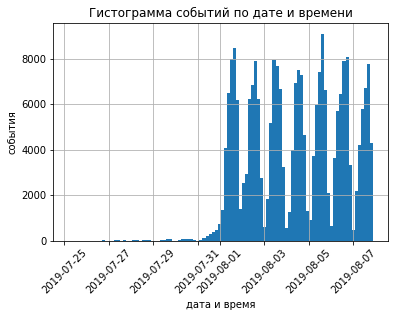

In [17]:
# Построим гистограмму по дате и времени
data['event_timestamp'].hist(bins=100)
plt.xticks (rotation = 45)
plt.rcParams ['figure.figsize'] = [12, 6]
plt.title('Гистограмма событий по дате и времени')
plt.xlabel('дата и время')
plt.ylabel('события')
plt.show()

На гистограмме видно, что одинаково полные данные у нас есть с 1 августа 2019 года. Отбросим события до 01.08.2019

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   device_id_hash   244126 non-null  int64         
 2   event_timestamp  244126 non-null  datetime64[ns]
 3   exp_id           244126 non-null  int64         
 4   date             244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [19]:
data_actual = (data.loc[data['date'] >= '2019-08-01']).reset_index()
len(data_actual)

241298

In [20]:
print('Количество отброшенных данных составляет', round((1 - len(data_actual)/len(data))*100, 2), '%')

Количество отброшенных данных составляет 1.16 %


Так как количество отброшенных данных меньше 5%, то это не повлияет на дальнейшие результаты исследования

- Рассчистаем количество "отброшенных" пользователей

In [21]:
print('Количество "отброшенных" пользователей равно', data['device_id_hash'].nunique() - data_actual['device_id_hash'].nunique())

Количество "отброшенных" пользователей равно 17


- Проверим, что есть пользователи из всех трёх экспериментальных групп.

In [22]:
exp_id_grouped = data_actual.groupby('exp_id').count()
exp_id_grouped['index']

exp_id
246    79425
247    77147
248    84726
Name: index, dtype: int64

In [23]:
exp_id_grouped = (data.groupby('exp_id').agg({'device_id_hash':'count'}).reset_index())
exp_id_grouped

,exp_id,device_id_hash
0,246,80304
1,247,78075
2,248,85747


В данных есть данные по всем трем экспереминтальным группам.

**Вывод**

Изначально в логе было 244126 событий и 7551 пользователей. В среднем на каждого пользователя приходится 20 событий (медиана).
По гистограмме определили, что полные данные есть с 1 августа и все предыдущие события удалили. Это составило 1,16% и 17 пользователей мы "потеряли".
В данных представлены все три экспереминтальные группы.

### Воронка событий

- Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [24]:
events_groupted = (data_actual.groupby('event_name')
                    .agg({'index':'count'}).reset_index()
                    .sort_values(by='index', ascending=False)
                  )
events_groupted = events_groupted.rename(
    columns = {'event_name': 'event_name',
           'index': 'event_cnt'
          }
)
events_groupted

,event_name,event_cnt
1,MainScreenAppear,117431
2,OffersScreenAppear,46350
0,CartScreenAppear,42365
3,PaymentScreenSuccessful,34113
4,Tutorial,1039


Наиболее частое событием было "отображение главной страницы", а наиболее редкое "обращение к справке". События в порядке убывания их частоты:
 - отображение главной страницы
 - отображение экрана предложения
 - отображение карточки товара
 - экран успешной оплаты
 - обращение к справке

- Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [25]:
device_id_hash_cnt = (data_actual.groupby(['event_name'])
                 .agg({'device_id_hash': 'nunique'}).reset_index()
                )
events_groupted = events_groupted.merge(device_id_hash_cnt, on='event_name')
events_groupted['share_users,%'] = round(events_groupted['device_id_hash']/(data_actual['device_id_hash'].nunique()) * 100, 2)
events_groupted = events_groupted.rename(
    columns = {'device_id_hash': 'user_cnt'
          }
)
events_groupted

,event_name,event_cnt,user_cnt,"share_users,%"
0,MainScreenAppear,117431,7419,98.47
1,OffersScreenAppear,46350,4593,60.96
2,CartScreenAppear,42365,3734,49.56
3,PaymentScreenSuccessful,34113,3539,46.97
4,Tutorial,1039,840,11.15


Наибольшее количество пользователей совершили событие "отображение главной страницы" и доля пользователей хотя бы раз совершивших это событие составляет почти 98.5%.

- Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

- отображение главной страницы - первое событие
- отображение экрана предложения - второе событие
- отображение карточки товара - третье событие
- экран успешной оплаты - последние событие
- обращение к справке - не каждый пользователь обращается к справке и сделать это может на любом этапе, поэтому конверсию для данного события не считаем

- Рассчитаем какая доля пользователей проходит на следующий шаг воронки.

In [26]:
events_groupted['conversion,%'] = round((events_groupted['user_cnt'].pct_change()+1)*100, 2)

# Оставим в таблице значения, которые выстраиваются в последовательную цепочку
# и которые необходимо учитывать при расчете воронки
conversion_table = events_groupted.loc[0:3]
conversion_table

,event_name,event_cnt,user_cnt,"share_users,%","conversion,%"
0,MainScreenAppear,117431,7419,98.47,NaN
1,OffersScreenAppear,46350,4593,60.96,61.91
2,CartScreenAppear,42365,3734,49.56,81.30
3,PaymentScreenSuccessful,34113,3539,46.97,94.78


In [27]:
total_conversion = round(conversion_table.loc[3, 'user_cnt']/conversion_table.loc[0, 'user_cnt']*100, 2)
print('Доля пользователей, которая доходит от первого события до оплаты -', total_conversion,'%')

Доля пользователей, которая доходит от первого события до оплаты - 47.7 %


**Вывод**

Обращение к справке не входит в последовательность событий, так как может возникнуть на любом этапе или совсем не использоваться при совершении покупки.
Поэтому этот шаг не будет учитываться при расчете воронки.
Максимальное количество пользователей - 98.47% совершают первый шаг воронки "отображение главной страницы".
Больше всего пользователей отсеивается на втором шаге "отображение экрана предложения", конверсия по сравнению с первым шагом составляет 61.91%. Тереятся почти 38% пользователей.
Доля пользователей, которая доходит от первого события до оплаты составляет 47.7 %

### Изучим результаты эксперимента

- Составим таблицу с общим количество пользователей по группам. 

In [28]:
group_data = data_actual.pivot_table(index='exp_id',values='device_id_hash',aggfunc='nunique')
group_data

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


Общее количество пользователей по группам распределилось следущим образом:
- 246 группа - 2484 пользователя
- 247 группа - 2513 пользователя
- 248 группа - 2537 пользователя

In [29]:
grouped_funnel = data_actual.pivot_table(index='exp_id', columns ='event_name', values='device_id_hash',aggfunc='nunique').reset_index()
grouped_funnel = grouped_funnel[['exp_id', 'CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear', 'PaymentScreenSuccessful']]
grouped_funnel['total'] = [group_data['device_id_hash'][246], group_data['device_id_hash'][247], group_data['device_id_hash'][248]]
grouped_funnel

event_name,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,total
0,246,1266,2450,1542,1200,2484
1,247,1238,2476,1520,1158,2513
2,248,1230,2493,1531,1181,2537


- A/A - тест. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

1) Нулевая гипотеза - нет различий между выборками 246 и 247.

2) Альтернативная гипотеза - есть различия между выборками 246 и 247.

In [30]:
alpha = 0.05 # критический уровень статистической значимости

successes = np.array([grouped_funnel.loc[0, 'PaymentScreenSuccessful'], grouped_funnel.loc[1, 'PaymentScreenSuccessful']])
trials = np.array([grouped_funnel.loc[0, 'total'], grouped_funnel.loc[1, 'total']])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод**
Так как не получилось отвергнуть нулевую гипотезу, что между выборками 246 и 247 нет различий, то считаем A/A тест успешным. Он подтвердил отсутствие статистических критериев разницы между выборками 246 и 247.

- Напишем функцию для проверки гипотез - z_test и функцию автоматической проверки гипотез - auto_test

In [31]:
def z_test (success, trials, alpha):
    # пропорция успехов в первой группе:
    p1 = success[0] / trials[0]
    # пропорция успехов во второй группе:
    p2 = success[1] / trials[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (trials[0] + trials[1])
    # разница пропорций в датасетах
    difference = p1 - p2
 
    z_value = difference / mth.sqrt(p_combined *(1-p_combined) * (1/trials[0] + 1/trials[1]))
    
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', "{0:.3f}".format(p_value))

    if (p_value < alpha):
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [32]:
# Функция на вход получает порядковый номер группы в таблице и параметр альфа, и возвращает результаты проверки гипотез
def auto_test (gr1, gr2, alpha):
    alpha_test = alpha
    cnt_users = ([grouped_funnel['total'][gr1], grouped_funnel['total'][gr2]])
    cnt_MainScreenAppear = ([grouped_funnel['MainScreenAppear'][gr1], grouped_funnel['MainScreenAppear'][gr2]])
    cnt_OffersScreenAppear = ([grouped_funnel['OffersScreenAppear'][gr1], grouped_funnel['OffersScreenAppear'][gr2]])
    cnt_CartScreenAppear = ([grouped_funnel['CartScreenAppear'][gr1], grouped_funnel['CartScreenAppear'][gr2]])
    cnt_PaymentScreenSuccessful = ([grouped_funnel['PaymentScreenSuccessful'][gr1], grouped_funnel['PaymentScreenSuccessful'][gr2]])
    
    print('Результаты теста по долям общего числа пользователей и пользователей, открывших главную страницу')
    z_test(cnt_MainScreenAppear, cnt_users, alpha_test)
    
    print('Результаты теста по долям общего числа пользователей и пользователей, открывших страницу предложения')
    z_test(cnt_OffersScreenAppear, cnt_users, alpha_test)
    
    print('Результаты теста по долям общего числа пользователей и пользователей, открывших карточку товара')
    z_test(cnt_CartScreenAppear, cnt_users, alpha_test)
    
    print('Результаты теста по долям общего числа пользователей и пользователей, открывших экран успешной оплаты')
    z_test(cnt_PaymentScreenSuccessful, cnt_users, alpha_test)

- Сделаем проверку контрольных групп А/A

1) Нулевая гипотеза - нет различий между выборками 246 и 247.

2) Альтернативная гипотеза - есть различия между выборками 246 и 247.

In [33]:
auto_test (0, 1, 0.05)

Результаты теста по долям общего числа пользователей и пользователей, открывших главную страницу
p-значение:  0.757
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Результаты теста по долям общего числа пользователей и пользователей, открывших страницу предложения
p-значение:  0.248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Результаты теста по долям общего числа пользователей и пользователей, открывших карточку товара
p-значение:  0.229
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Результаты теста по долям общего числа пользователей и пользователей, открывших экран успешной оплаты
p-значение:  0.115
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод**
По результатам A/A теста всех этапов воронки нет оснований считать, что выборка 246 и 247 статистически значимо отличаются.
Соответственно, можем сказать, что разбиение на группы работает корректно.

Самым популярным событием стало "отображение главной страницы".

- Сравним результаты группы с изменненным шрифтом с каждой из контрольных групп в отдельности по каждому событию.

Сравнение группы 246 и 248:

1) Нулевая гипотеза - нет различий между выборками 246 и 248;

2) Альтернативная гипотеза - есть различия между выборками 246 и 248.

In [34]:
auto_test (0, 2, 0.05)

Результаты теста по долям общего числа пользователей и пользователей, открывших главную страницу
p-значение:  0.295
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Результаты теста по долям общего числа пользователей и пользователей, открывших страницу предложения
p-значение:  0.208
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Результаты теста по долям общего числа пользователей и пользователей, открывших карточку товара
p-значение:  0.078
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Результаты теста по долям общего числа пользователей и пользователей, открывших экран успешной оплаты
p-значение:  0.212
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравнение группы 247 и 248:

1) Нулевая гипотеза - нет различий между выборками 247 и 248.

2) Альтернативная гипотеза - есть различия между выборками 247 и 248.

In [35]:
auto_test (1, 2, 0.05)

Результаты теста по долям общего числа пользователей и пользователей, открывших главную страницу
p-значение:  0.459
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Результаты теста по долям общего числа пользователей и пользователей, открывших страницу предложения
p-значение:  0.920
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Результаты теста по долям общего числа пользователей и пользователей, открывших карточку товара
p-значение:  0.579
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Результаты теста по долям общего числа пользователей и пользователей, открывших экран успешной оплаты
p-значение:  0.737
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


- Соединим две контрольные группы в общую группу

In [36]:
grouped_funnel.loc[3] = [249, grouped_funnel['CartScreenAppear'][0]+grouped_funnel['CartScreenAppear'][1], grouped_funnel['MainScreenAppear'][0]+grouped_funnel['MainScreenAppear'][1], grouped_funnel['OffersScreenAppear'][0]+grouped_funnel['OffersScreenAppear'][1], grouped_funnel['PaymentScreenSuccessful'][0]+grouped_funnel['PaymentScreenSuccessful'][1], grouped_funnel['total'][0]+grouped_funnel['total'][1]]
grouped_funnel

event_name,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,total
0,246,1266,2450,1542,1200,2484
1,247,1238,2476,1520,1158,2513
2,248,1230,2493,1531,1181,2537
3,249,2504,4926,3062,2358,4997


Сравнение группы 248 и 250 (объединенные группы 246 и 247):

1) Нулевая гипотеза - нет различий между выборками 248 и 250.

2) Альтернативная гипотеза - есть различия между выборками 248 и 250.

In [37]:
auto_test (3, 2, 0.05)

Результаты теста по долям общего числа пользователей и пользователей, открывших главную страницу
p-значение:  0.294
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Результаты теста по долям общего числа пользователей и пользователей, открывших страницу предложения
p-значение:  0.434
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Результаты теста по долям общего числа пользователей и пользователей, открывших карточку товара
p-значение:  0.182
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Результаты теста по долям общего числа пользователей и пользователей, открывших экран успешной оплаты
p-значение:  0.600
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод**
- При уровне значимости 0.05 нулевая гипотеза не подтверждается в A/A тесте и в A/B тесте, как для одной(246), так и для второй(247) контрольных групп.
- Так же нулевая гипотеза не подтверждается для A/B теста при объединении контрольных групп 246 и 247.
- Соответсвенно, нет оснований считать, что группа с измененным шрифтом статистически значимо отличается от любой из трех контрольных групп.

- При проверке статистических гипотез выбрали уровень значимости равный 0,05.
- Считаю, что мы провели 4 проверки статистических гипотез:
  - 246 группа / 247 группа
  - 246 группа / 248 группа
  - 247 группа / 248 группа
  - 249 группа / 248 группа
- Для уточнения правильности выбранного уровня значимости можно использовать метод Бонферонни. bonferroni_alpha = 0,05/4 = 0.0125 Во всех тестах мы получили p-value больше этого значения, значит ни в одном из тестов не получилось отвергнуть нулевую гипотезу для сравнения групп. Значит наблюдаемые данные не подтверждают наличие различий между группами и нет необходимости менять уровень значимости равный 0,05.

**Общие выводы**
- В датасете находится 244126 строки. Данные качественные без пропущенных значений. Скорректировали названия столбцов.
- В первоначальном логе было 244126 событий и 7551 пользователей. В среднем на каждого пользователя приходится 20 событий (медиана).
- По результатам проверки выявлены и удалены дубликаты (0,17%). Именен тип данных integer на datetime в столбце с датой 'EventTimestamp'
- По гистограмме установлено, что одинаково полные данные у нас есть в промежутке  с 01.08.2019 по 07.08.2019. Более старые данные удалены (1,16%). В результате этого мы также "потеряли" 17 пользователей из дальнейших исследований.
- Наиболее частое событием было "отображение главной страницы", а наиболее редкое "обращение к справке". События в порядке убывания их частоты:
1) отображение главной страницы - 117431
2) отображение экрана предложения - 46350
3) отображение карточки товара - 42365
4) экран успешной оплаты - 34113
5) обращение к справке - 1039
- Список событий, которые вошли в воронку:
1) отображение главной страницы
2) отображение экрана предложения
3) отображение карточки товара
4) экран успешной оплаты
- Обращение к справке не входит в последовательность событий, так как может возникнуть на любом этапе или совсем не использоваться при совершении покупки.
- Максимальное количество пользователей - 98.47% совершают первый шаг воронки "отображение главной страницы". Больше всего пользователей отсеивается на втором шаге "отображение экрана предложения", конверсия по сравнению с первым шагом составляет 61.91%. Тереятся почти 38% пользователей. Доля пользователей, которая доходит от первого события до оплаты составляет 47.7 %
- Общее количество пользователей по группам распределилось следущим образом:
    - 246 группа - 2484 пользователя
    - 247 группа - 2513 пользователя
    - 248 группа - 2537 пользователя
- В рамках A/A - теста проверяли следующие гипотезы:

     1) Нулевая гипотеза - нет различий между выборками 246 и 247
     
     2) Альтернативная гипотеза - есть различия между выборками 246 и 247
     
По результатам A/A теста всех этапов воронки нет оснований считать, что выборка 246 и 247 статистически значимо отличаются. Соответственно, можем сказать, что разбиение на группы работает корректно.
- В рамках проведения A/B тестов по группам 246 с 248, 247 с 248 и общей группы 249 с 248 проверяли следующие гипотезы:

     1) Нулевая гипотеза - нет различий между группой до изменений и после изменений шрифта
     
     2) Альтернативная гипотеза - есть различия между группой до изменений и после изменений шрифта
     
- При уровне значимости 0.05 нулевая гипотеза не подтверждается. Соответсвенно, нет оснований считать, что группа с измененным шрифтом статистически значимо отличается от любой из трех контрольных групп.